Nutrient comparisons with edited dataset using surface instead of 2m for depth.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import os
%matplotlib inline

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
nutrients_2015 = pd.read_excel('/home/eolson/Desktop/PSFbottledata_CN_edits_EOCor.xlsx')

In [5]:
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [6]:
nutrients_2015.shape

(896, 12)

In [7]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [8]:
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])

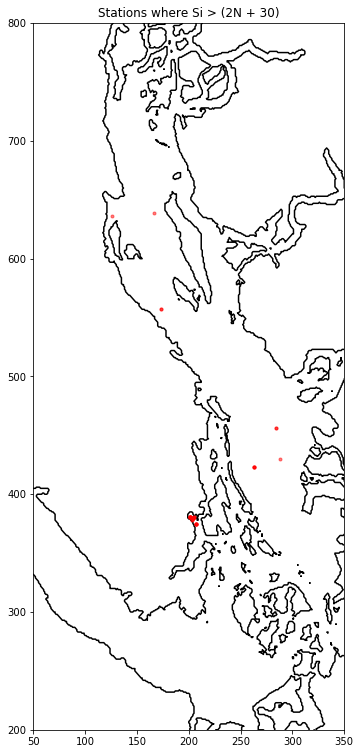

In [9]:
fig, ax = plt.subplots(figsize = (13,13))
for n in nutrients_2015.index:
    if nutrients_2015['si'][n] > (2*nutrients_2015['no23'][n]+30):
        ax.plot(nutrients_2015['Xind'][n], nutrients_2015['Yind'][n], 'r.', alpha = 0.5)
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(200, 800)
ax.set_xlim(50, 350)
ax.set_title('Stations where Si > (2N + 30)');

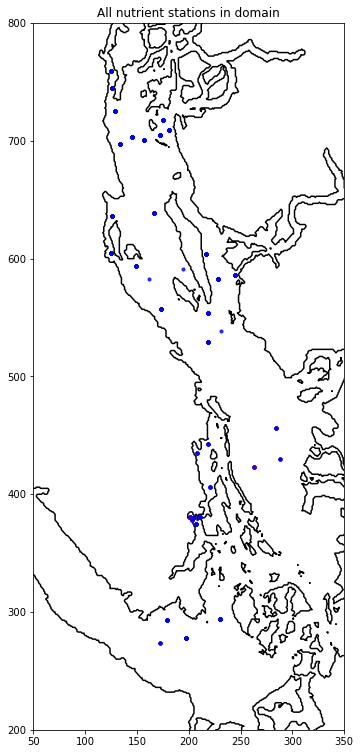

In [10]:
fig, ax = plt.subplots(figsize = (13,13))
for n in nutrients_2015.index:
    if nutrients_2015['si'][n] > (2*nutrients_2015['no23'][n]+30):
        ax.plot(nutrients_2015['Xind'][n], nutrients_2015['Yind'][n], 'r.', alpha = 0.5)
    else:
        ax.plot(nutrients_2015['Xind'][n], nutrients_2015['Yind'][n], 'b.', alpha = 0.5)
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(200, 800)
ax.set_xlim(50, 350)
ax.set_title('All nutrient stations in domain');

In [28]:
list_of_model_si = np.ma.masked_array(np.zeros((894)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((894)), mask = True)
list_of_latitude = np.ma.masked_array(np.zeros((894)), mask = True)
list_of_days = np.ma.masked_array(np.empty(894, dtype='datetime64[s]'), mask = True)
t = 0
for n in nutrients_2015.index:
    Yind = int(nutrients_2015['Yind'][n])
    Xind = int(nutrients_2015['Xind'][n])
    date = pd.to_datetime(nutrients_2015['date'][n])
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    if ((nutrients_2015['depth'][n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
        si_val = nuts.variables['silicon'][0, 18, Yind, Xind]
        ni_val = nuts.variables['nitrate'][0, 18, Yind, Xind]
        list_of_model_si.mask[t] = False
        list_of_model_si[t] = si_val
        list_of_model_ni.mask[t] = False
        list_of_model_ni[t] = ni_val
        list_of_latitude.mask[t] = False
        list_of_latitude[t] = nutrients_2015['lat'][n]
        list_of_days.mask[t] = False
        list_of_days[t] = pd.to_datetime(nutrients_2015['date'][n])
    elif ((nutrients_2015['depth'][n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
        si_val = nuts.variables['silicon'][0, 0, Yind, Xind]
        ni_val = nuts.variables['nitrate'][0, 0, Yind, Xind]
        list_of_model_si.mask[t] = False
        list_of_model_si[t] = si_val
        list_of_model_ni.mask[t] = False
        list_of_model_ni[t] = ni_val
        list_of_latitude.mask[t] = False
        list_of_latitude[t] = nutrients_2015['lat'][n]
        list_of_days.mask[t] = False
        list_of_days[t] = pd.to_datetime(nutrients_2015['date'][n])
    t = t + 1

In [29]:
np.ma.count(list_of_model_ni)

879

In [30]:
list_of_days.shape

(894,)

In [31]:
cs_ni = np.ma.masked_array(nutrients_2015['no23'].values, mask = list_of_model_ni.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = list_of_model_si.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = list_of_model_si.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = list_of_model_si.mask)

In [32]:
cs_ni.shape

(894,)

In [40]:
pd.to_datetime(pd.Timestamp(list_of_days[0]))

Timestamp('2015-01-26 00:00:00')

In [42]:
cb_model_si = np.array([])
cb_model_ni = np.array([])
cb_cs_si = np.array([])
cb_cs_ni = np.array([])
cb_depths = np.array([])
cb_dates = np.array([])
cb_latitudes = np.array([])
for n in range(894):
    if stations.mask[n] == False:
        if stations[n][:2] == 'CB':
            cb_model_si = np.append(cb_model_si, list_of_model_si[n])
            cb_model_ni = np.append(cb_model_ni, list_of_model_ni[n])
            cb_cs_si = np.append(cb_cs_si, cs_si[n])
            cb_cs_ni = np.append(cb_cs_ni, cs_ni[n])
            cb_depths = np.append(cb_depths, depths[n])
            cb_dates = np.append(cb_dates, pd.to_datetime(pd.Timestamp(list_of_days[n])))
            cb_latitudes = np.append(cb_latitudes, list_of_latitude[n])
            list_of_model_ni.mask[n] = True
            list_of_model_si.mask[n] = True
            cs_ni.mask[n] = True
            cs_si.mask[n] = True

In [43]:
np.ma.count(list_of_model_ni)

791

bias =  -1.60908877053
RMSE = 6.03158947359
Willmott = 0.892195658043


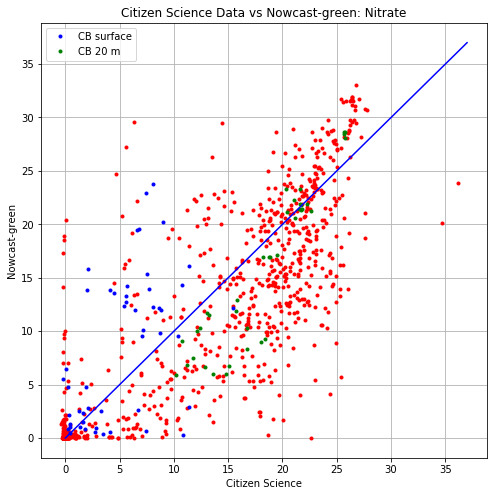

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_ni, list_of_model_ni, 'r.')
ax.plot(cb_cs_ni[cb_depths == 2], cb_model_ni[cb_depths == 2], 'b.', label = 'CB surface')
ax.plot(cb_cs_ni[cb_depths == 20], cb_model_ni[cb_depths == 20], 'g.',label = 'CB 20 m' )
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
plt.legend()
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_ni)**2) /
                              791)))
xbar = np.mean(cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_ni - xbar))**2))))

bias =  -8.97155599574
RMSE = 14.7675240993
Willmott = 0.767680766337


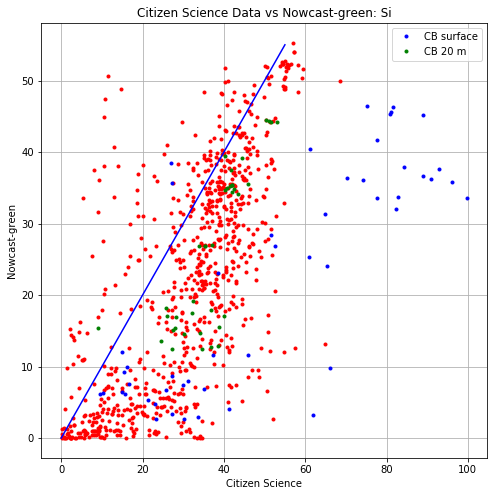

In [21]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(cb_cs_si[cb_depths == 2], cb_model_si[cb_depths == 2], 'b.', label = 'CB surface')
ax.plot(cb_cs_si[cb_depths == 20], cb_model_si[cb_depths == 20], 'g.',label = 'CB 20 m' )
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
plt.legend()
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              791)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

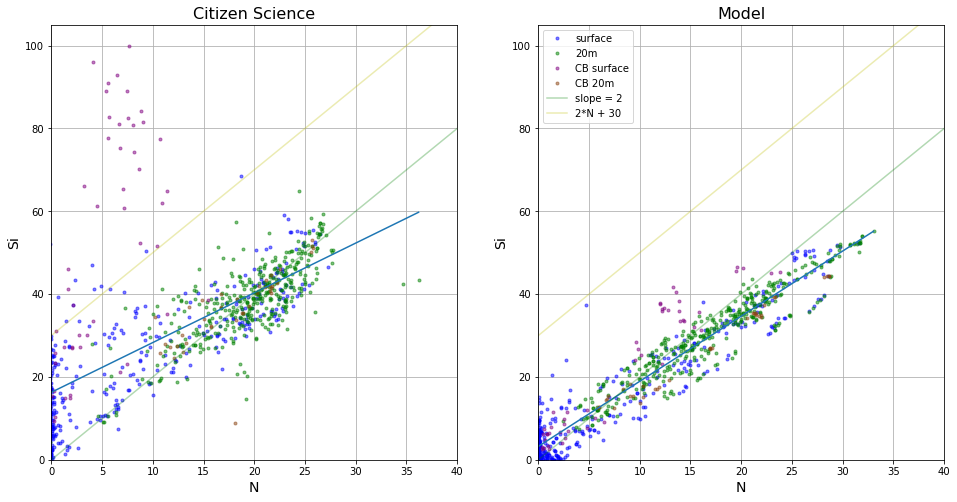

In [17]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_ni[nutrients_2015['depth'].values == 2], cs_si[nutrients_2015['depth'].values == 2], 
           'b.', alpha = 0.5)
ax[0].plot(cs_ni[nutrients_2015['depth'].values == 20], 
           cs_si[nutrients_2015['depth'].values == 20], 
           'g.', alpha = 0.5)
ax[0].plot(cb_cs_ni[cb_depths == 20], cb_cs_si[cb_depths == 20], 
           '.', alpha = 0.5, color = 'saddlebrown')
ax[0].plot(cb_cs_ni[cb_depths == 2], cb_cs_si[cb_depths == 2], 
           '.', alpha = 0.5, color = 'purple')
ax[0].plot(np.unique(cs_ni), np.poly1d(np.polyfit(cs_ni, cs_si, 1))(np.unique(cs_ni)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 2], 
           list_of_model_si[nutrients_2015['depth'].values == 2], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 20], 
           list_of_model_si[nutrients_2015['depth'].values == 20], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(cb_model_ni[cb_depths == 2], cb_model_si[cb_depths == 2], 
           '.', alpha = 0.5, color = 'purple', label = 'CB surface')
ax[1].plot(cb_model_ni[cb_depths == 20], cb_model_si[cb_depths == 20], 
           '.', alpha = 0.5, color = 'saddlebrown', label = 'CB 20m')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [18]:
m1, b1 = np.polyfit(cs_ni, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.20081121919
CitSci y int = 16.2994839487
model slope = 1.57235166359
model y int = 3.23199914498


In [44]:
list_of_days.shape

(894,)

In [46]:
depths[:10]

masked_array(data = [-- -- -- -- 2 20 2 20 -- --],
             mask = [ True  True  True  True False False False False  True  True],
       fill_value = 999999)

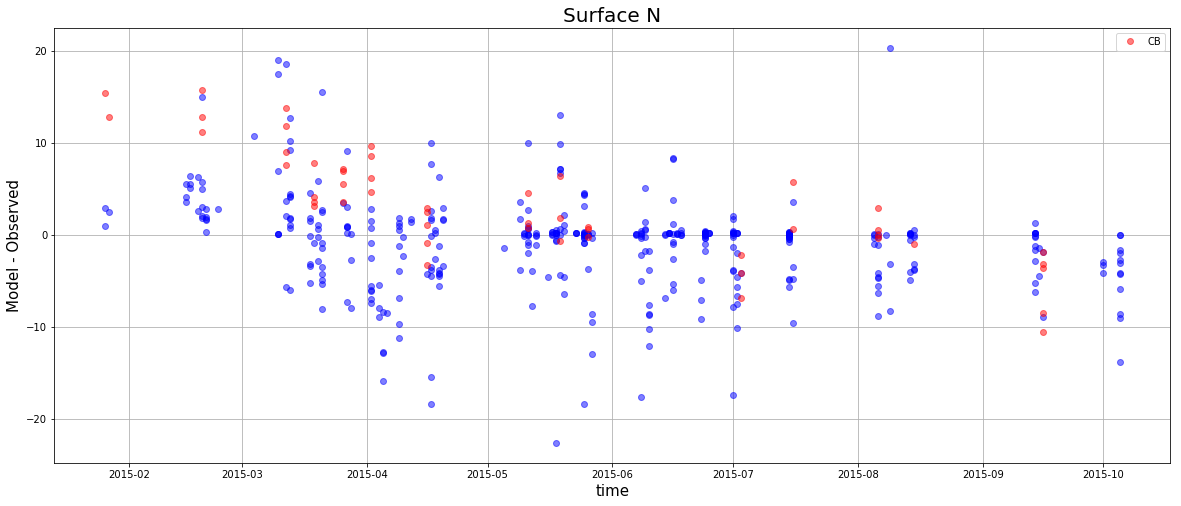

In [53]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_days[depths ==2], list_of_model_ni[depths==2] - cs_ni[depths==2],
        'bo', alpha =0.5)
ax.plot(cb_dates[cb_depths ==2], cb_model_ni[cb_depths==2] - cb_cs_ni[cb_depths==2],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface N', fontsize = 20)
ax.legend();

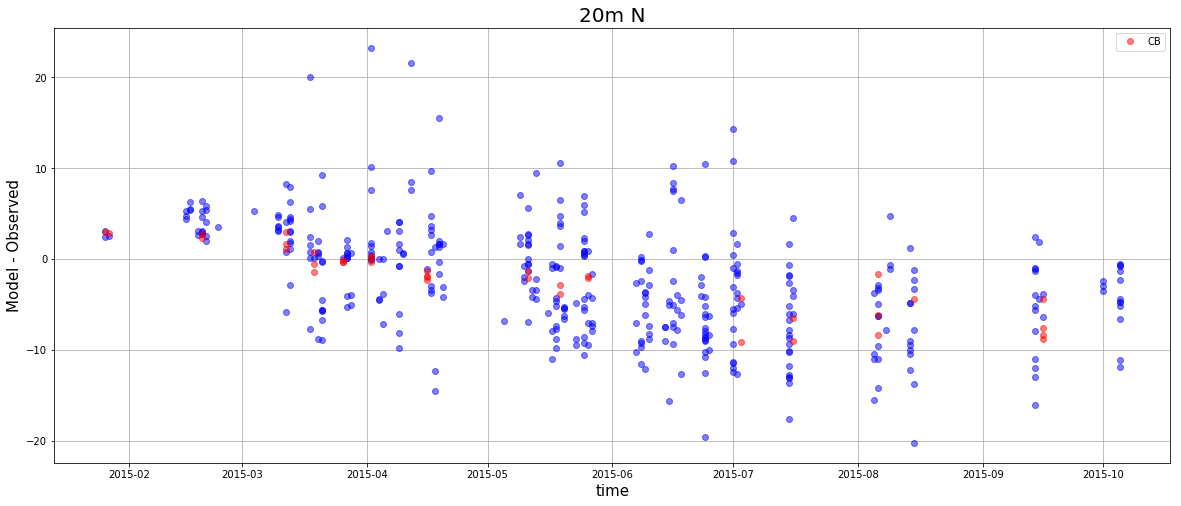

In [54]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_days[depths ==20], list_of_model_ni[depths==20] - cs_ni[depths==20],
        'bo', alpha =0.5)
ax.plot(cb_dates[cb_depths ==20], cb_model_ni[cb_depths==20] - cb_cs_ni[cb_depths==20],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('20m N', fontsize = 20)
ax.legend();

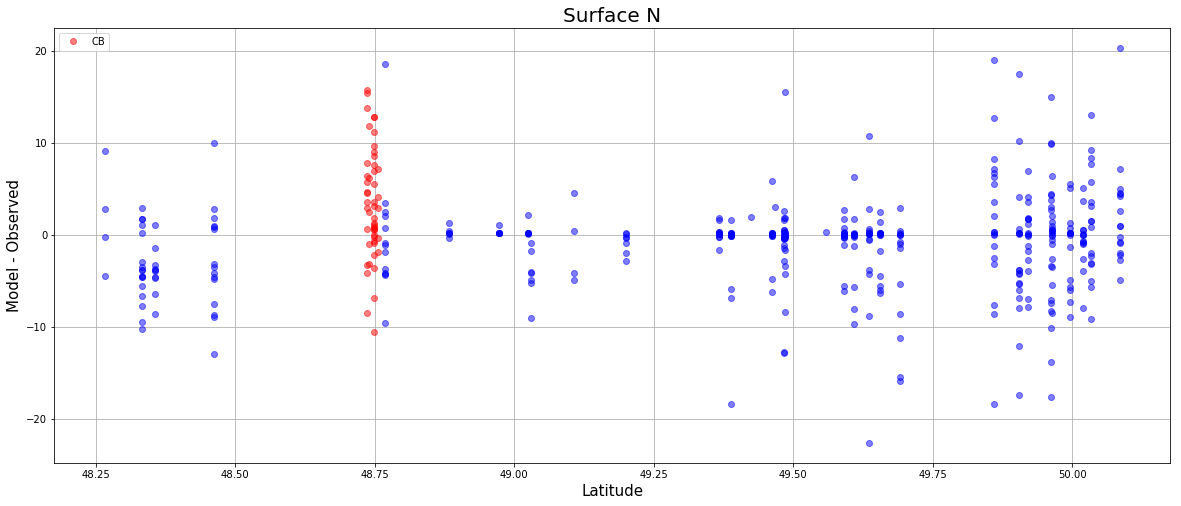

In [55]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_latitude[depths ==2], list_of_model_ni[depths==2] - cs_ni[depths==2],
        'bo', alpha =0.5)
ax.plot(cb_latitudes[cb_depths ==2], cb_model_ni[cb_depths==2] - cb_cs_ni[cb_depths==2],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface N', fontsize = 20)
ax.legend();

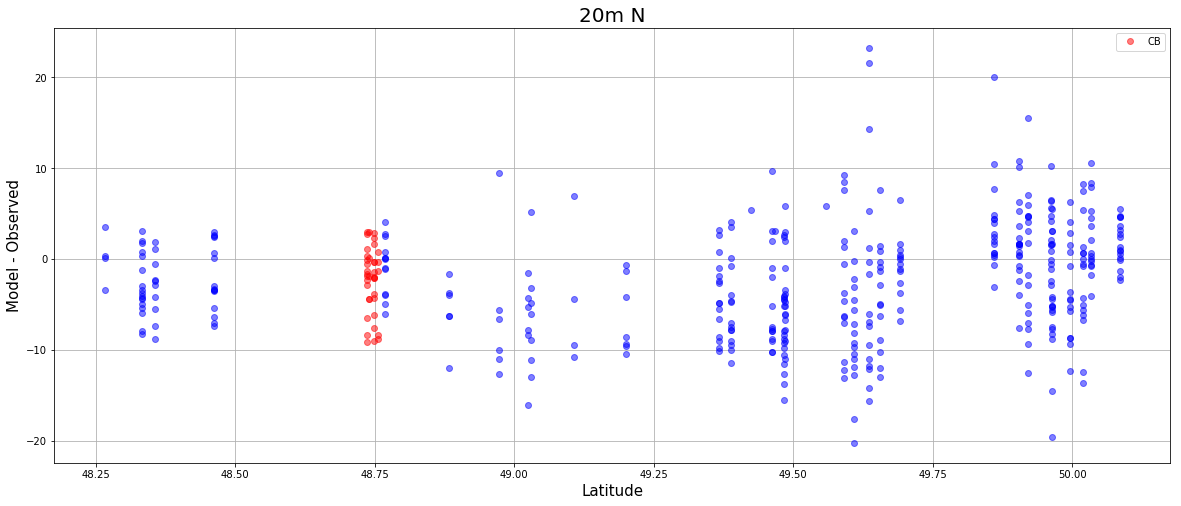

In [56]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_latitude[depths ==20], list_of_model_ni[depths==20] - cs_ni[depths==20],
        'bo', alpha =0.5)
ax.plot(cb_latitudes[cb_depths ==20], cb_model_ni[cb_depths==20] - cb_cs_ni[cb_depths==20],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('20m N', fontsize = 20)
ax.legend();

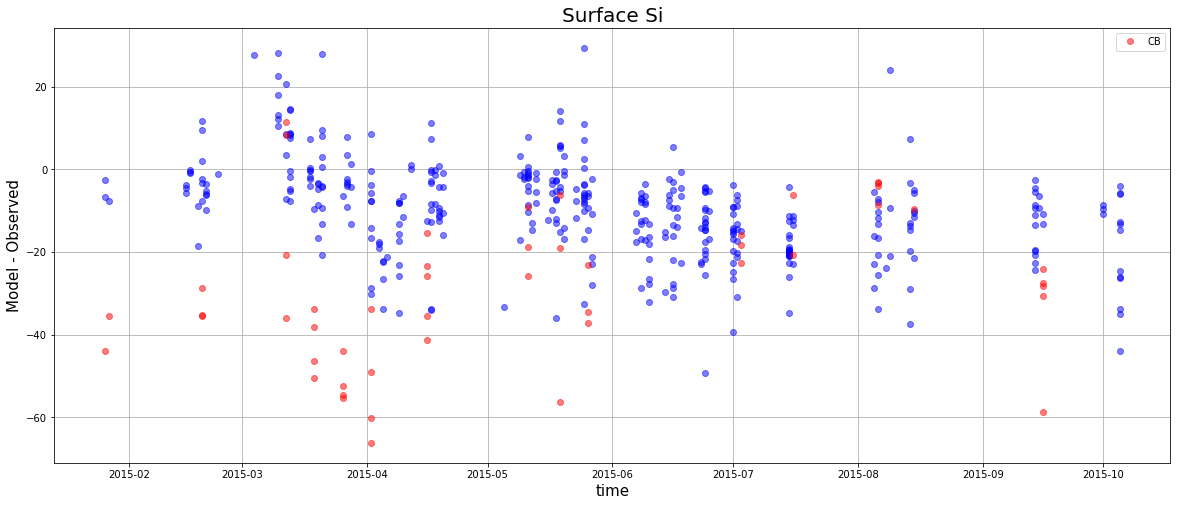

In [57]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_days[depths ==2], list_of_model_si[depths==2] - cs_si[depths==2],
        'bo', alpha =0.5)
ax.plot(cb_dates[cb_depths ==2], cb_model_si[cb_depths==2] - cb_cs_si[cb_depths==2],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface Si', fontsize = 20)
ax.legend();

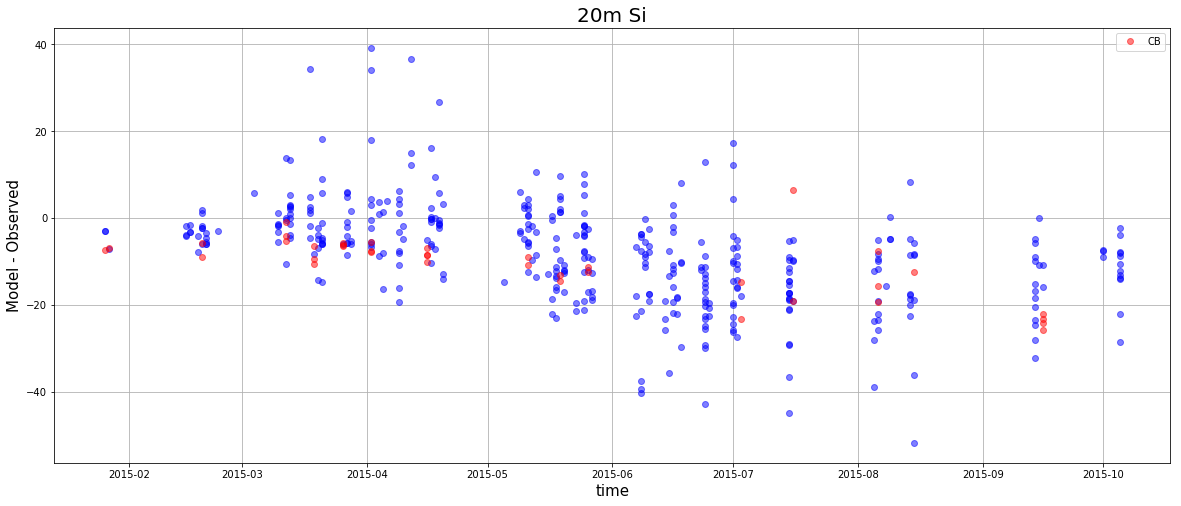

In [58]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_days[depths ==20], list_of_model_si[depths==20] - cs_si[depths==20],
        'bo', alpha =0.5)
ax.plot(cb_dates[cb_depths ==20], cb_model_si[cb_depths==20] - cb_cs_si[cb_depths==20],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('20m Si', fontsize = 20)
ax.legend();

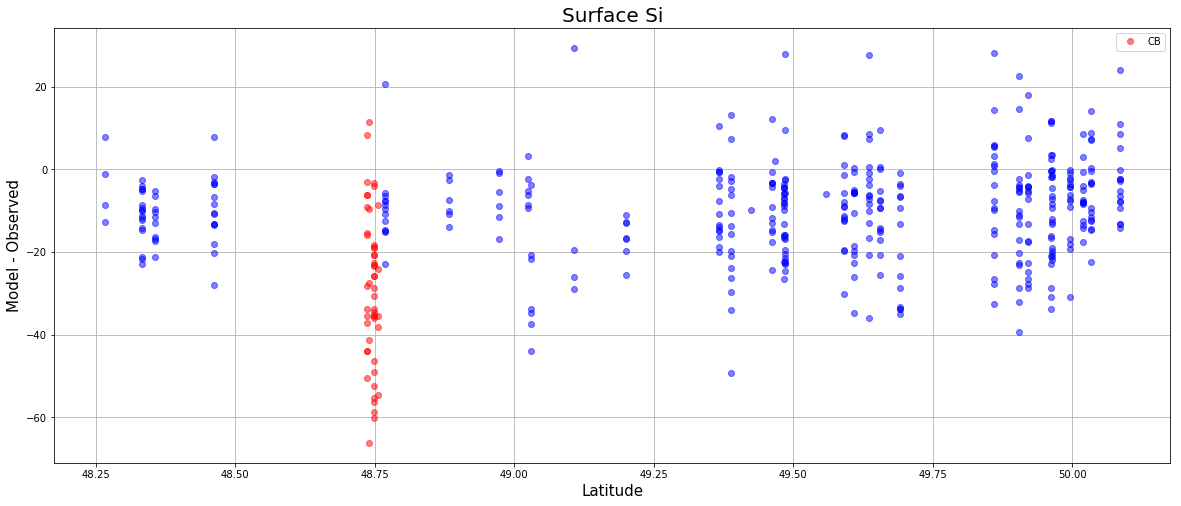

In [59]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_latitude[depths ==2], list_of_model_si[depths==2] - cs_si[depths==2],
        'bo', alpha =0.5)
ax.plot(cb_latitudes[cb_depths ==2], cb_model_si[cb_depths==2] - cb_cs_si[cb_depths==2],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface Si', fontsize = 20)
ax.legend();

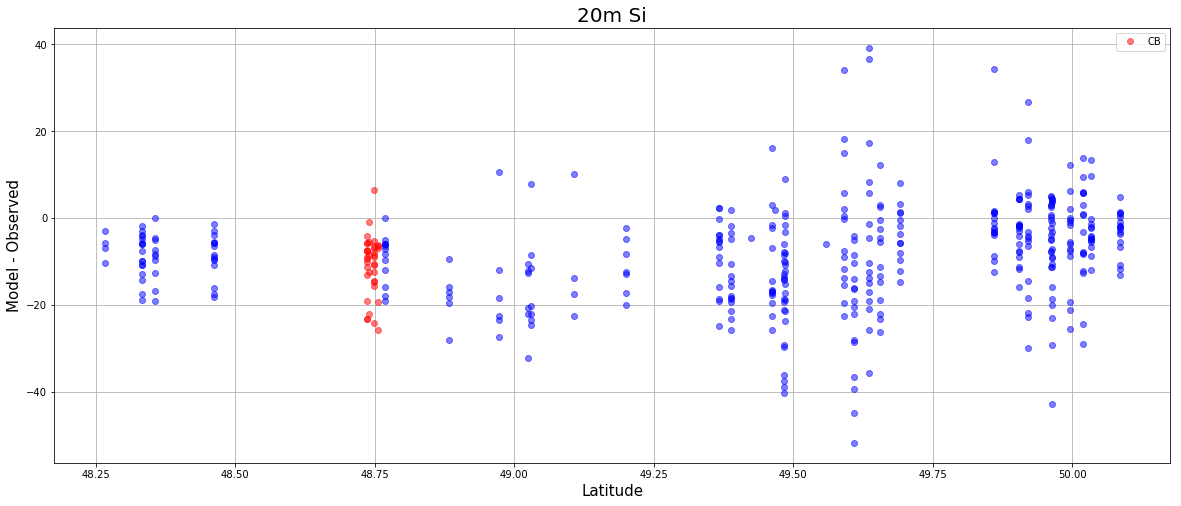

In [60]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_latitude[depths ==20], list_of_model_si[depths==20] - cs_si[depths==20],
        'bo', alpha =0.5)
ax.plot(cb_latitudes[cb_depths ==20], cb_model_si[cb_depths==20] - cb_cs_si[cb_depths==20],
        'ro', alpha =0.5, label = 'CB')
ax.grid('on')
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('20m Si', fontsize = 20)
ax.legend();

# Histogram of points that have Si > (2N + 30)

In [79]:
lats = np.ma.masked_array(nutrients_2015['lat'].values, mask = list_of_model_ni.mask)
lons = np.ma.masked_array(nutrients_2015['lon'].values, mask = list_of_model_ni.mask)
times = np.ma.masked_array(nutrients_2015['date'].values, mask = list_of_model_ni.mask)

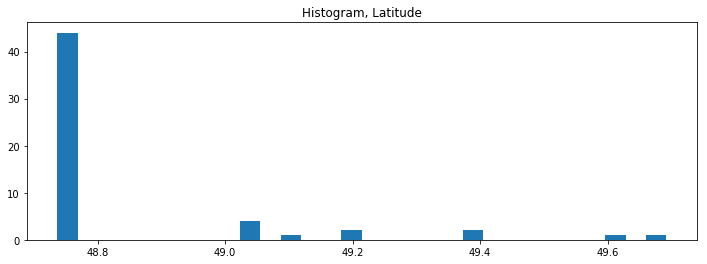

In [112]:
fig, ax = plt.subplots(figsize = (12,4))
n, bins, patches = ax.hist(lats[cs_si > (2*cs_ni + 30)], bins=30)
ax.set_title('Histogram, Latitude')

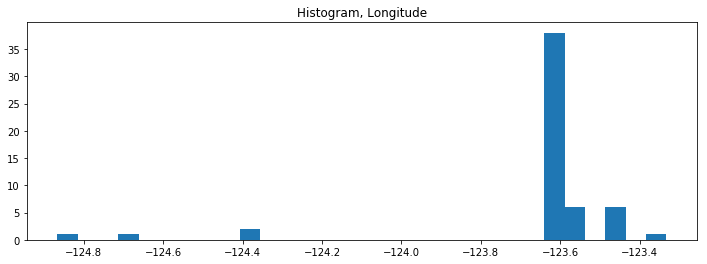

In [102]:
fig, ax = plt.subplots(figsize = (12,4))
n, bins, patches = ax.hist(lons[cs_si > (2*cs_ni + 30)], bins=30)
ax.set_title('Histogram, Longitude')

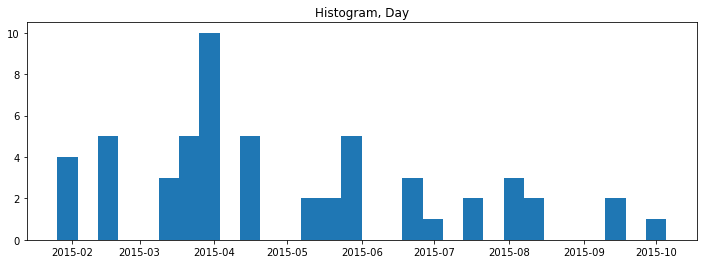

In [103]:
fig, ax = plt.subplots(figsize = (12,4))
n, bins, patches = ax.hist(times[cs_si > (2*cs_ni + 30)], bins=30)
ax.set_title('Histogram, Day')

In [65]:
list_of_model_si2 = np.array([])
list_of_model_sal2 = np.array([])
list_of_depths = np.array([])
for n in nutrients_2015.index:
    if nutrients_2015['station'][n][:2] == 'CB':
        Yind = int(nutrients_2015['Yind'][n])
        Xind = int(nutrients_2015['Xind'][n])
        date = pd.to_datetime(nutrients_2015['date'][n])
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        fname2 = 'SalishSea_1d_{}_{}_grid_T.nc'.format(datestr, datestr)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname2))
        if ((nutrients_2015['depth'][n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            si_val = nuts.variables['silicon'][0, 18, Yind, Xind]
            sal_val = nuts2.variables['vosaline'][0,18,Yind,Xind]
            list_of_model_si2 = np.append(list_of_model_si2, si_val)
            list_of_model_sal2 = np.append(list_of_model_sal2, sal_val)
            list_of_depths = np.append(list_of_depths, 20)
        elif ((nutrients_2015['depth'][n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            si_val = nuts.variables['silicon'][0, 0, Yind, Xind]
            sal_val = nuts2.variables['vosaline'][0,0,Yind,Xind]
            list_of_model_si2 = np.append(list_of_model_si2, si_val)
            list_of_model_sal2 = np.append(list_of_model_sal2, sal_val)
            list_of_depths = np.append(list_of_depths, 0)

In [70]:
import pickle

In [72]:
cb_si2 = pickle.load(open('cbsi.pkl', 'rb'))
cb_sal2 = pickle.load(open('cbsal.pkl', 'rb'))
cb_depths2 = pickle.load(open('depths.pkl', 'rb'))

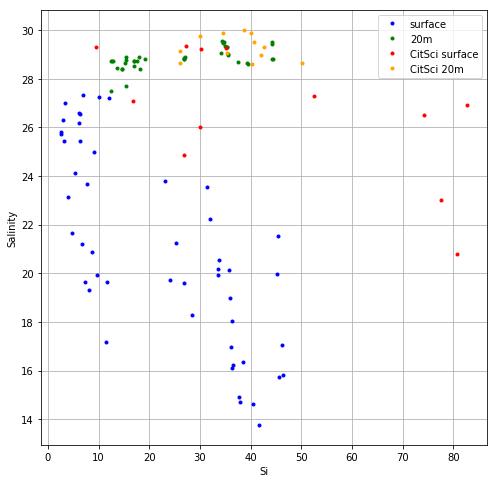

In [73]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_model_si2[list_of_depths == 0], list_of_model_sal2[list_of_depths==0], 
        'b.', label = 'surface')
ax.plot(list_of_model_si2[list_of_depths == 20], list_of_model_sal2[list_of_depths==20], 
        'g.', label = '20m')
ax.plot(cb_si2[cb_depths2 == 2], cb_sal2[cb_depths2==2], 
        '.',color = 'red', label = 'CitSci surface')
ax.plot(cb_si2[cb_depths2 == 20], cb_sal2[cb_depths2==20], 
        '.', color='orange', label = 'CitSci 20m')
ax.grid('on')
ax.set_xlabel('Si')
ax.set_ylabel('Salinity')
plt.legend()
#ax.set_xlim(0,50)
#ax.set_ylim(0,50)